# King County, Washington State, USA - Housing Prices

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy import optimize
import numpy as np
from sklearn.model_selection import train_test_split
from scipy import optimize
from matplotlib import pyplot
import sys
from tqdm import tqdm as tqdm
from matplotlib.pyplot import figure

from sklearn.preprocessing import PolynomialFeatures
#%matplotlib inline

In [ ]:
data = pd.read_csv("Data/kc_house_data.csv")
plt.figure()
data.hist(figsize=(20, 15), bins=50)
#scatter_matrix(data)
plt.show()

# Data Preparation

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null int64
view             21597 non-null int64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null int64
yr_built         21597 non-null int64
yr_renovated     21597 non-null int64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB


In [4]:
def data_preprocessing(data):
    #Returns processed data in numpy matrix
    #Drops ID field and converts date to year only
    data_w = data
    data_w = data.drop(columns=['id'])
    data_w["date"] = pd.to_datetime(data_w["date"]).dt.year
    
    #move price to the end of df
    price = data_w.pop('price')
    data_w['price']=price
    return data_w.values


In [5]:
#Split data into train and test set
data_X = data_preprocessing(data)
X, X_test, y, y_test = train_test_split(data_X[:, :18], data_X[:, 19], test_size=0.20, random_state=23)

#Set aside test set
test_set = np.concatenate([X_test, y_test[:, None]], axis=1)
np.savetxt("Data/test_data.txt", test_set, fmt='%s')

#Split data into train and cross validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=23)


# Linear Regression Model

In [74]:
# Cost Function
def linearRegCostFunction(X, y, theta, lambda_):
    
    # Initialize some useful values
    m, n = X.shape # X matrix shape
    
    
    #Add intercept
    #print(np.ones(m).reshape(m,1).shape, X)
    X = np.concatenate([np.ones(m).reshape(m,1), X], axis=1)
    
    #Compute h
    h = X @ theta
    
    #Regularized Cost Function
    J = np.sum((h - y)**2)/(2*m)
    reg_term = (lambda_/(2*m)) * np.sum(theta[1:]**2)
    J = J + reg_term
    
    #Gradient Computation
    #Simple Gradient without reg for bias
    grad = (1/m) * ((h - y) @ X)
    
    # Compute gradient with reg for non-bias
    grad[1:] = grad[1:] + (lambda_/m)*theta[1:]

    return J, grad

def trainLinearReg(linearRegCostFunction, X, y, lambda_=0.0, maxiter=200):
    # Useful values
    m, n = X.shape # X matrix shape
    # Initialize Theta
    initial_theta = np.zeros(n+1)

    # Create "short hand" for the cost function to be minimized
    costFunction = lambda t: linearRegCostFunction(X, y, t, lambda_)

    # Now, costFunction is a function that takes in only one argument
    options = {'maxiter': maxiter}

    # Minimize using scipy
    res = optimize.minimize(costFunction, initial_theta, jac=True, method='TNC', options=options)
    
    return res.x

def learningCurve(X_train, y_train, X_val, y_val, lambda_=0):
    # Number of training examples
    m = y_train.size

    # You need to return these values correctly
    error_train = np.zeros(m)
    error_val   = np.zeros(m)

    #Compute error_train
    for i in tqdm(range(1, m+1)):
        theta_train = trainLinearReg(linearRegCostFunction, X_train[:i,:], y_train[:i], lambda_)
        
        error_train[i-1], _ = linearRegCostFunction(X_train[:i, :], y_train[:i], theta_train, 0)
        error_val[i-1], _ = linearRegCostFunction(X_val, y_val, theta_train, 0)
        
    return error_train, error_val

def featureNormalize(X):

    mu = np.mean(X, axis=0)
    X_norm = X - mu

    sigma = np.std(X_norm, axis=0, ddof=1)
    X_norm /= sigma
    return X_norm, mu, sigma

def predict(X, theta):
    
    # Initialize some useful values
    m, n = X.shape # X matrix shape
    
    
    #Add intercept
    X = np.concatenate([np.ones(m).reshape(m,1), X], axis=1)
    
    #Compute h
    h = X @ theta
    
    return h

In [7]:
## testing cost function
#test theta with ones
theta_test = np.ones(18+1)
lambda_ = 0
# Compute cost with test theta
J, grad = linearRegCostFunction(X_train, y_train, theta_test, lambda_)
J, grad

(155997289530.55603,
 array([ -4.20703778e+05,  -8.47432310e+08,  -1.52396788e+06,
         -1.03822996e+06,  -1.10827651e+09,  -6.17402134e+09,
         -6.79801744e+05,  -1.26168424e+04,  -2.14740669e+05,
         -1.44249125e+06,  -3.50842715e+06,  -9.31911706e+08,
         -1.76364799e+08,  -8.29669771e+08,  -5.60134285e+07,
         -4.12611268e+10,  -2.00250050e+07,   5.14164449e+07,
         -9.82266274e+08]))

In [8]:
#Train Model
res = trainLinearReg(linearRegCostFunction, X_train, y_train, lambda_=0.0, maxiter=200)
trained_theta = res



In [10]:
#Compute Training and Validation error for increasing number of training data used
error_train_n, error_val_n = learningCurve(X_train[:3000,:], y_train[:3000], X_val[:3000,:], y_val[:3000], lambda_=0)


100%|██████████| 3000/3000 [00:54<00:00, 54.73it/s]


# ML Diagnostics
## Learning Curve

# Training Examples	Train Error	Cross Validation Error
  	1		0.000000	103235591944.231506
  	2		22941348146.983505	26373490777.169853
  	3		20298564628.531811	23517339059.156189
  	4		22009987262.694374	25916220127.775215
  	5		21941410478.376411	25531709770.483189
  	6		20640024139.120407	24148718113.732204
  	7		21820245639.635239	25432597054.256516
  	8		21345388067.513607	24769670588.332150
  	9		20420831078.674255	23918485466.947132
  	10		21767901407.932110	25151448785.360569


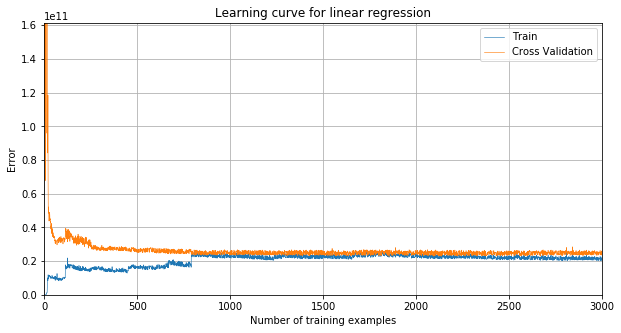

In [11]:
#Plot Learning Curves
m = y_train[:3000].size

print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(10):
    print('  \t%d\t\t%f\t%f' % (i+1, error_train_n[-i], error_val_n[-i]))


figure(num=1, figsize=(10, 5))
pyplot.plot(np.arange(1, m+1), error_train_n, np.arange(1, m+1), error_val_n, lw=0.6)
pyplot.title('Learning curve for linear regression')
pyplot.legend(['Train', 'Cross Validation'])
pyplot.xlabel('Number of training examples')
pyplot.ylabel('Error')
pyplot.axis([0, m, 0, 161361944543])
plt.grid()
pyplot.show()

    

## Learning Curve - Interpretation

- Graph Properties
    - Low training set size: J_CV is high & J_train is low
    - Large training set size: J_CV ≃ J_train
    
-> Model does not seem to suffer from high variance but from high bias

Steps to address high bias situation:
- Adding features: <span style="color:orange">Not possible, look into feauture engineering</span> 
- Adding polynomial features: <span style="color:green">Next Step</span> 
- After polynomials: determine best lambda: <span style="color:green">Next Step</span> 

# Adding Polynomial Features

In [24]:
#Polynomial dimensions
p = 2

#Add polynomial features
poly = PolynomialFeatures(p, include_bias=False)

X_test_p = poly.fit_transform(X_test)
X_train_p = poly.fit_transform(X_train)
X_val_p = poly.fit_transform(X_val)

#Normalize X_test_p and extract sigma & mu
X_train_p, mu, sigma = featureNormalize(X_train_p)

#Normalize X_test_p & X_val_p using sigma & mu
X_test_p -= mu
X_test_p /= sigma
X_val_p -= mu
X_val_p /= sigma

# Plot learning curve

In [13]:
#Compute Training and Validation error for increasing number of training data used
error_train, error_val = learningCurve(X_train_p[:3000,:], y_train[:3000], X_val_p[:3000,:], y_val[:3000], lambda_=0)

100%|██████████| 3000/3000 [04:16<00:00, 11.69it/s]


# Training Examples	Train Error Norm	Cross Error Norm	Train Error Poly	Cross Error Poly
  	3000		22941348146.983505	26373490777.169853	13987268125.717159	17329120027.515991
  	2500		21216517547.358624	23936071984.683979	13411697961.688835	19876588891.287449
  	2000		23445031589.939171	25277841576.022583	13724362294.081570	25116688068.831417
  	1500		22844219483.262371	24893377670.375526	13689951825.688129	26534094177.895710
  	1000		22104019313.643044	23877714737.589260	13311486956.342754	32912216783.149124
  	500		16379375459.907236	26371644218.051937	10508548205.247272	24220353860.753376


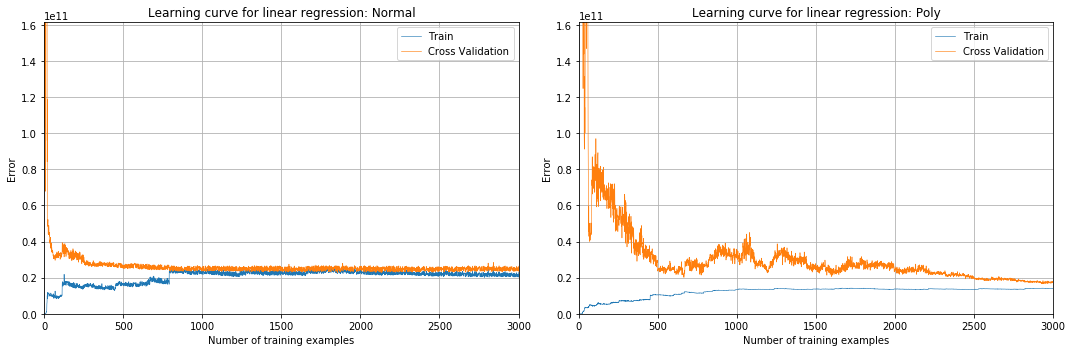

In [83]:
#Plot Learning Curves
m = y_train[:3000].size

print('# Training Examples\tTrain Error Norm\tCross Error Norm\tTrain Error Poly\tCross Error Poly')
for i in range(2999, 0, -500):
    print('  \t%d\t\t%f\t%f\t%f\t%f' % (i+1, error_train_n[i], error_val_n[i],error_train[i], error_val[i]))


figure(num=1, figsize=(15, 5))
pyplot.subplot(121)
pyplot.plot(np.arange(1, m+1), error_train_n, np.arange(1, m+1), error_val_n, lw=0.6)
pyplot.title('Learning curve for linear regression: Normal')
pyplot.legend(['Train', 'Cross Validation'])
pyplot.xlabel('Number of training examples')
pyplot.ylabel('Error')
pyplot.axis([0, m, 0, 161361944543])
plt.grid()    


#figure(num=1, figsize=(10, 5))
pyplot.subplot(122)
pyplot.plot(np.arange(1, m+1), error_train, np.arange(1, m+1), error_val, lw=0.6)
pyplot.title('Learning curve for linear regression: Poly')
pyplot.legend(['Train', 'Cross Validation'])
pyplot.xlabel('Number of training examples')
pyplot.ylabel('Error')
pyplot.axis([0, m, 0, 161361944543])
plt.grid()
plt.tight_layout()
pyplot.show()

In [10]:
#Full dataset learning curve#Compute Training and Validation error for increasing number of training data used
error_train_fu, error_val_fu = learningCurve(X_train_p, y_train, X_val_p, y_val, lambda_=0)

100%|██████████| 13821/13821 [2:32:39<00:00,  1.51it/s]


### Learning curve for full training set

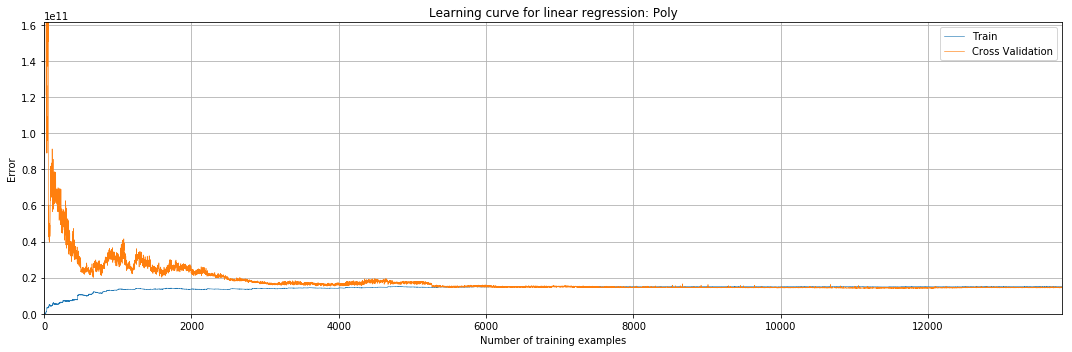

In [15]:
m = y_train.size

figure(num=1, figsize=(15, 5))
pyplot.plot(np.arange(1, m+1), error_train_fu, np.arange(1, m+1), error_val_fu, lw=0.6)
pyplot.title('Learning curve for linear regression: Poly')
pyplot.legend(['Train', 'Cross Validation'])
pyplot.xlabel('Number of training examples')
pyplot.ylabel('Error')
pyplot.axis([0, m, 0, 161361944543])
plt.grid()
plt.tight_layout()
pyplot.show()

# Lambda Selection

In [72]:
def validationCurve(X, y, Xval, yval):

 
    # Selected values of lambda 
    lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
    
    # Init vectors containing errors
    error_train = np.zeros(len(lambda_vec))
    error_val = np.zeros(len(lambda_vec))
    
    for i in range(len(lambda_vec)):
        lambda_ = lambda_vec[i]
        
        #Train model based on i-th lambda
        theta_train = trainLinearReg(linearRegCostFunction, X, y, lambda_)
        
        #Compute error for train & validation set
        error_train[i], _ = linearRegCostFunction(X, y, theta_train, 0)
        error_val[i], _ = linearRegCostFunction(Xval, yval, theta_train, 0)
        


    return lambda_vec, error_train, error_val

lambda		Train Error	Validation Error
 0.000000	15103065781.234987	14526329094.786806
 0.001000	15121965029.475712	14574344084.389965
 0.003000	15113231185.322329	14581794309.061121
 0.010000	15128096019.373924	14662350562.269341
 0.030000	15216481607.980999	14804947382.299564
 0.100000	15101812230.567081	14541700601.922867
 0.300000	15094328876.407801	14499756496.538509
 1.000000	15132747384.622303	14816149881.327812
 3.000000	15091853694.597752	14436763411.772865
 10.000000	15118329453.242186	14596930943.917435


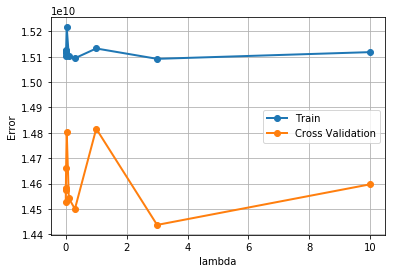

In [73]:
lambda_vec, error_train, error_val = validationCurve(X_train_p, y_train, X_val_p, y_val)

pyplot.plot(lambda_vec, error_train, '-o', lambda_vec, error_val, '-o', lw=2)
pyplot.legend(['Train', 'Cross Validation'])
pyplot.xlabel('lambda')
pyplot.ylabel('Error')
pyplot.grid()

print('lambda\t\tTrain Error\tValidation Error')
for i in range(len(lambda_vec)):
    print(' %f\t%f\t%f' % (lambda_vec[i], error_train[i], error_val[i]))

Note: Shouldn't Train error constantly increase?

# Final model and prediction

In [57]:
#Final Model theta:
theta_final = trainLinearReg(linearRegCostFunction, X_train_p, y_train, lambda_=3.0, maxiter=200)

#Predict

result = predict(X_test_p, theta_final)

cost = (1/(2*m))*np.sum((result - y_test)**2)

In [58]:
result2 = result.reshape(4320,1)
y_test2 = y_test.reshape(4320,1)
comparison = np.concatenate([result2, y_test2], axis=1)

In [70]:
#np.savetxt("result.csv", comparison, fmt='%10.5f')